In [7]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve2d,correlate,correlation_lags,butter,sosfilt
import scipy.stats as stats
import matplotlib.pylab as pl
from scipy import interpolate

In [8]:
folder='csv/13_08_2021/DTS/'
date = pd.read_csv(folder + 'date.csv', delimiter=';', header=None).values.flatten().astype(np.datetime64)
time = pd.to_timedelta ( pd.read_csv(folder + 'tdelta.csv', delimiter=';', header=None).values.flatten() ).values
temp = pd.read_csv(folder + 'temperature.csv', header=None).values
pos = pd.read_csv(folder + 'position.csv', header=None).values.flatten()

# Filtrage des données
On applique un moving average 2D sur les données, ce qui revient à appliquer un filtre passe bas.

Le window temporel est de 1h et le window spatial est de 2 mètres

In [9]:
def moving_average_2d(x, w_time, w_spatial):
    x_padded = np.pad(x, [(w_time//2, w_time-1-w_time//2), (w_spatial//2, w_spatial-1-w_spatial//2)], mode='edge')
    return convolve2d(x_padded, np.ones((w_time, w_spatial)), 'valid')/(w_time*w_spatial)

w_time = int(60/2) #average sur 60 minutes
w_spatial = int(2/1) #average sur 2 mètres
dts = moving_average_2d(temp, w_time,w_spatial)

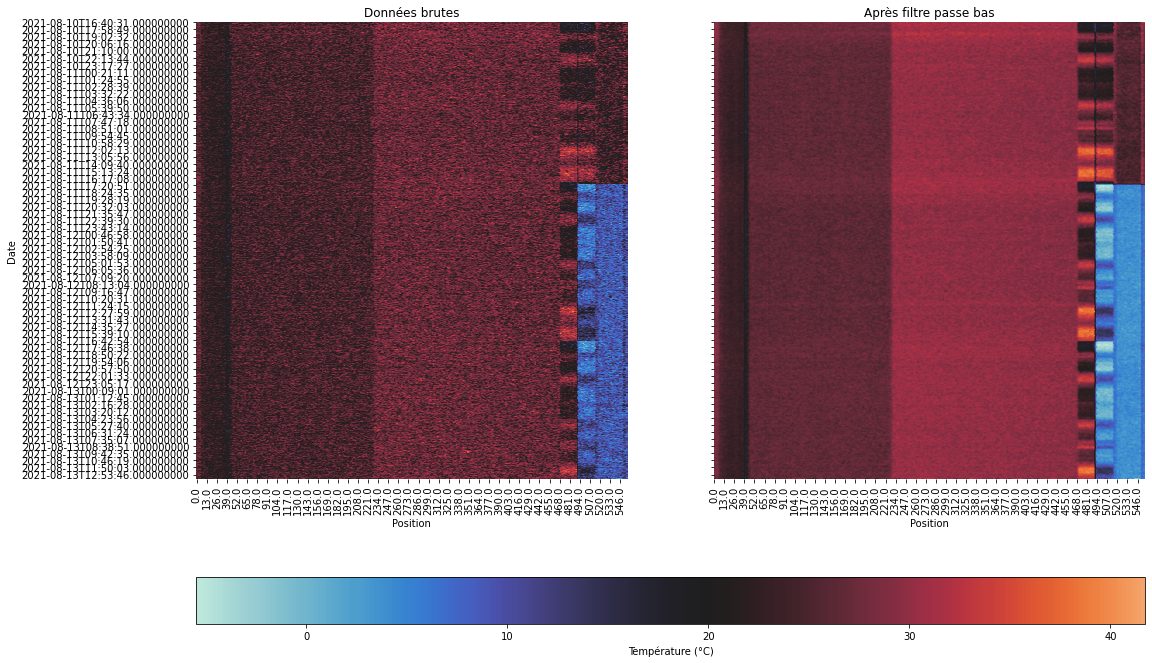

In [10]:
df1 = pd.DataFrame(data=temp, columns=pos, index=date)
df2 = pd.DataFrame(data=dts, columns=pos, index=date)

fig,axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(17,12))
axs[0].set_title('Données brutes')
im=sns.heatmap(df1, ax=axs[0],center=20, cbar=False)
axs[0].set_ylabel('Date')
axs[0].set_xlabel('Position')
axs[1].set_title('Après filtre passe bas')
sns.heatmap(df2, ax=axs[1],center=20, cbar=False)
axs[1].set_xlabel('Position')
mappable = im.get_children()[0]
cbar = plt.colorbar(mappable, ax = [axs[0],axs[1]],orientation = 'horizontal')
cbar.set_label('Température (°C)')
# plt.savefig('figures/filtre.png')

# Étude des sections 

Les sections sont les suivantes. On indique leur coordonnées approximatives.

##### Section 1  : Raccord 1 @ [0,8]
- La température autout de 0 m (proche de l'appareil) est autour de 28 °C (selon mes mesures avec le "gun")
- Le raccord mesure 8 mètres (je l'ai mesuré)

##### Section 2 : Chaudière 1 @ [8,38]
- La section de fibre qui est dans l'eau de la chaudière mesure un peu moins que 30 mètres,  autour de 29-28 mètres. 
- Il pourrait y avoir des comportements étrange au point de contact entre l'air et l'eau. 
- La température devrait être un peu plus basse dans l'eau que l'air ambiant. J'ai effectivement confirmé cela avec le "gun à température", il indiquait plutot autour de 20-22 °C. 

##### Section 3 : Spool @ [38,470]
- La température du spool devrait être assez uniforme, autour de la température ambiante du labo (~23-24 °C). 
- La fan du four soufflait sur une partie du spool, on verra peut-être des variations à cause de cela.

##### Section 4 : Four @ [470, 517]
- Le four effectue un cyclage de température qui a une durée de 24 heures, mais qui représente les variations de températures de l'extérieur durant une semaine complète.

##### Section 5 : Chaudière 2 @ [520, 547]
Remarque :  Même que chaudière 1
##### Section 6 : Raccord 2 @ [547, 555]
Remarque :  Même que raccord 1


#### Connecteurs:
Aux connecteurs, il pourrait y avoirs des baisses de températures soudaines qui d'étendent sur ~ 6 mètres avant et après le connecteur

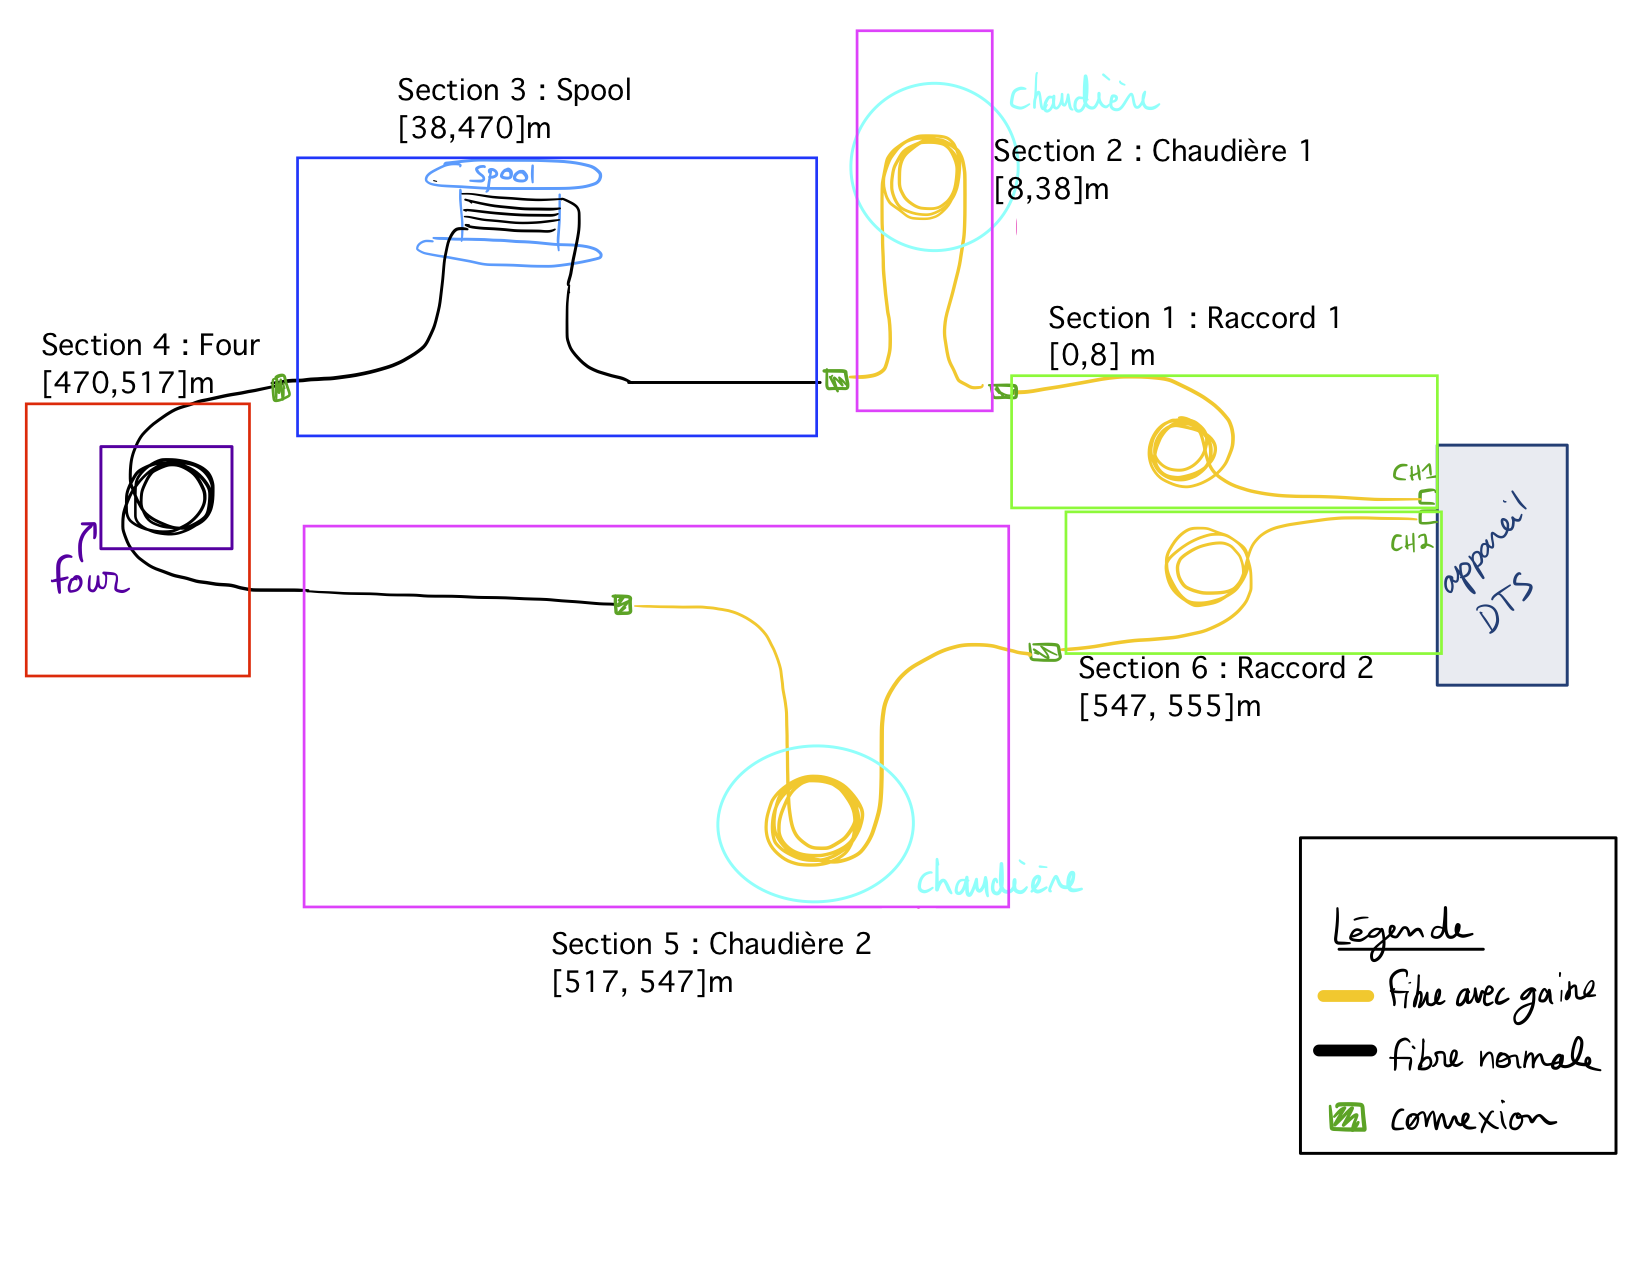

In [12]:
from IPython import display
display.Image("schema.png",retina=True)

## 1. Premier 50 mètres

Dans les premiers 50 mètres on voit:

##### Raccord 1
 - La température moyenne est autour de 26-28 degré, ce qui est attendu. Lors des mesures avec le "gun à température" il faisait autour de 28 proche de la connexion avec l'appareil.

##### Chaudière 1 
- La température est plus basse que la température ambiante comme attendu.

##### Connecteur 
- Il y une baisse de température anormale ici à cause du connecteur


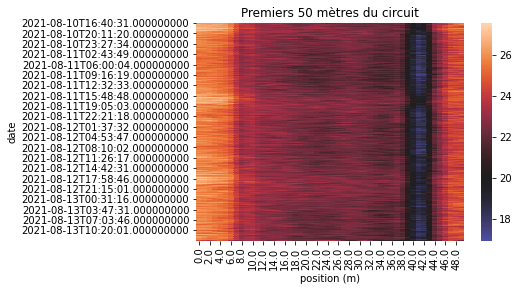

In [13]:
N=50
df = pd.DataFrame(data=dts[:,:N], columns=pos[:N], index=date)
_=plt.title('Premiers 50 mètres du circuit')
_=sns.heatmap(df,center=20, cbar=True)
_=plt.xlabel('position (m)')
_=plt.ylabel('date')

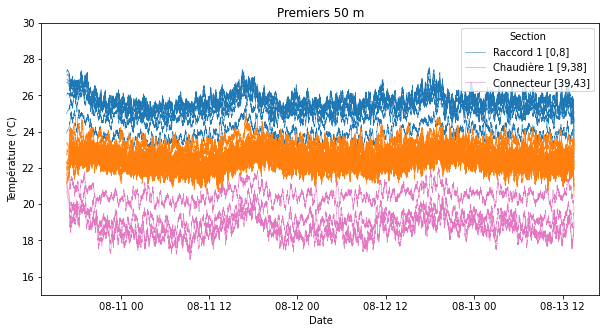

In [14]:

colors = ['tab:blue', 'tab:orange', 'tab:pink', 'tab:grey']
fig, ax = plt.subplots(figsize=(10,5))
plt.title('Premiers 50 m')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.ylim(15,30)
a = np.arange(0,8, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line1, = ax.plot(date,dts[:,j], linewidth=0.5, color=colors[0])
a = np.arange(9,38, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line2, = ax.plot(date,dts[:,j], linewidth=0.5, color=colors[1])
a = np.arange(39,43, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line3, = ax.plot(date,dts[:,j], linewidth=0.5, color=colors[2])
_=plt.legend([line1,line2,line3], ['Raccord 1 [0,8]', 'Chaudière 1 [9,38]','Connecteur [39,43]'], title='Section')

## 2. De 50 à 520 mètres
On voit : 
##### Spool @ [50, 467]
- On observe très clairement 2 sections, de 50 à 220 m et de 220 à 460 m . Je ne sais pas pourquoi. C'est très étrange. 
- On sépare en sous-sections:
    - Spool A : [50,229] 
    - Spool B : [230,467]
- La température moyenne est autour de 23-24 degrés pour la première partie, ce qui est attendu car c'est la température ambiante. Par contre, la deuxième partie à une température plus élevée. 
- On observe un pic de température en PM. On le voyait un peu dans le premiers 50 mètres mais c'est plus évident ici.

##### Four @ [468,517]
- La température suit le cyclage du four comme attendu.
- Dans une section du four, il y a clairement un problème à partir d'autour du 11 aout @ 15:48 et après 487 mètres. Je suspecte qu'une épissure ou une connexions se soit endommagée, ce qui crée un offset de température. Ce offset peut être corrigé manuellement.
- On sépare en sous-sections:
    - Frontière four : [467,470]
    - Four A (_Partie valide_) : [471,490] 
    - Four B (_Partie avec une anomalie_) : [491, 517] 


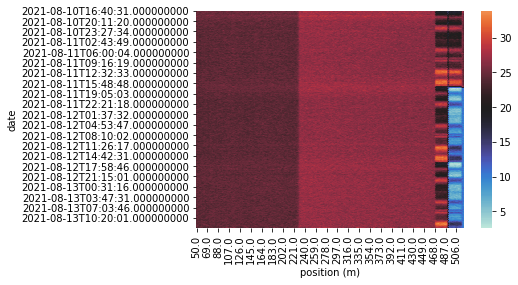

In [15]:
N1=50
N2=520
df = pd.DataFrame(data=dts[:,N1:N2], columns=pos[N1:N2], index=date)
plt.figure()
_=sns.heatmap(df,center=20, cbar=True)
_=plt.xlabel('position (m)')
_=plt.ylabel('date')

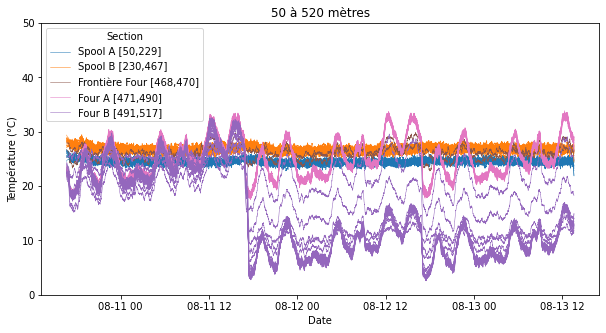

In [16]:

colors = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:purple']
fig, ax = plt.subplots(figsize=(10,5))
plt.title('50 à 520 mètres')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.ylim(0,50)

a = np.arange(50,229, step=10)
n = len(a)
for i in range(n):
    j = a[i]
    line1, = ax.plot(date,dts[:,j], linewidth=0.5, color=colors[0])

a = np.arange(230,467, step=10)
n = len(a)
for i in range(n):
    j = a[i]
    line2, = ax.plot(date,dts[:,j], linewidth=0.5, color=colors[1])

a = np.arange(468,470, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line3, = ax.plot(date,dts[:,j], linewidth=0.5, color=colors[2])

a = np.arange(471,490, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line4, = ax.plot(date,dts[:,j], linewidth=0.5, color=colors[3])

a = np.arange(491,517, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line5, = ax.plot(date,dts[:,j], linewidth=0.5, color=colors[4])

_ = plt.legend([line1,line2,line3,line4,line5], 
           ['Spool A [50,229]', 'Spool B [230,467]','Frontière Four [468,470]','Four A [471,490]','Four B [491,517]'], 
           title='Section')


### Correction du offset entre les deux sections du spool

In [17]:
offset = np.mean( dts[:,50:229]  )  -  np.mean( dts[:,230:467]  )
print('Le offset entre les deux sections du spool est de : {} °C'.format(offset))

#on applique une correction
dts_o = dts.copy() # On enregistre une copie de l'original
dts[:, 230:] -= np.absolute(offset)

Le offset entre les deux sections du spool est de : -2.293904929339508 °C


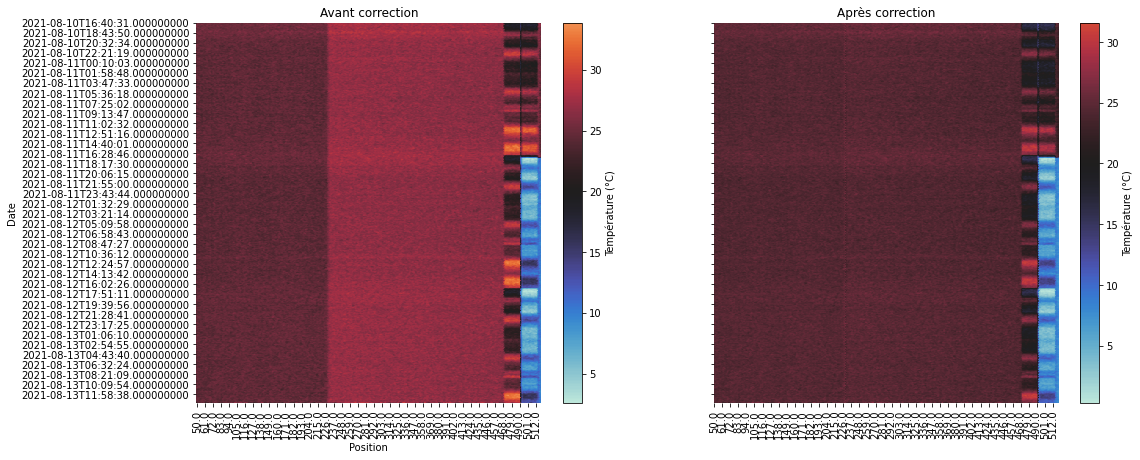

In [18]:
df1 = pd.DataFrame(data=dts_o[:, N1:N2], columns=pos[N1:N2], index=date)
df2 = pd.DataFrame(data=dts[:, N1:N2], columns=pos[N1:N2], index=date)

fig,axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(17,7))
axs[0].set_title('Avant correction')
im=sns.heatmap(df1, ax=axs[0],center=20, cbar=False)
axs[0].set_ylabel('Date')
axs[0].set_xlabel('Position')
mappable = im.get_children()[0]
cbar = plt.colorbar(mappable, ax = axs[0])
cbar.set_label('Température (°C)')
axs[1].set_title('Après correction')
axs[1].set_xlabel('Position')
im=sns.heatmap(df2, ax=axs[1],center=20, cbar=False)
mappable = im.get_children()[0]
cbar = plt.colorbar(mappable, ax = axs[1])
cbar.set_label('Température (°C)')

### Analyse en détail des données du four

**Pour faire l'analyse des données du four, on sélectionne seulement la section valide (A) du four.**

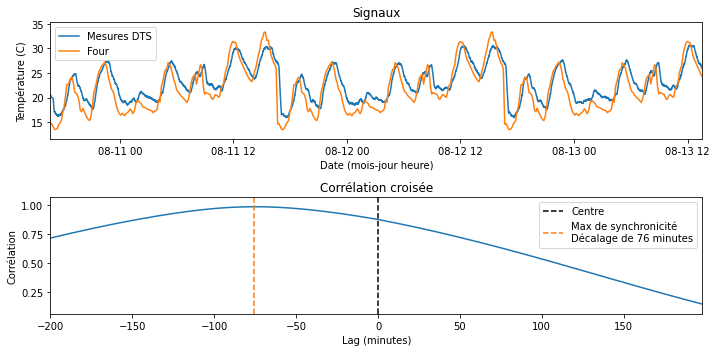

In [19]:
# Lire data du four
dtoven = pd.to_timedelta ( pd.read_csv('csv/13_08_2021/four/dt_four24h.csv',header=None).values.flatten() ).values
oven = pd.read_csv('csv/13_08_2021/four/temp_four24h.csv',header=None).values.flatten()
doven  = date[0] + dtoven
signal_date = np.concatenate( [ doven, doven + np.timedelta64(1, 'D'), doven + np.timedelta64(2, 'D') ] )
signal = np.concatenate( [oven,oven,oven])

# Upsample les données du four
dt = (signal_date - signal_date[0]).astype(np.float)/1e9 #secondes
f = interpolate.interp1d(dt, signal)
dt_upsample = (date - date[0])
signal_upsample = f(dt_upsample)

# On fait une moyenne sur la section du four
signal_dts = np.nanmean(dts[:,471:490], axis=1)

def crosscorr(d1, d2, lag):
    return stats.pearsonr(d1, np.roll(d2, lag))[0]

d1 = signal_upsample
d2 = signal_dts #le signal dts est pris à chaque 2 minutes. c'est celui qu'on va décaller
lags = correlation_lags(len(signal_dts),len(signal_upsample)) 
n = int(len(lags)/2)
lags_n = lags[n-100:n+100]
rs = [ crosscorr(d1, d2, lag) for lag in lags_n ]
m=lags_n[np.argmax(rs)]

fig, (ax_dts, ax_corr) = plt.subplots(2, 1, figsize=(10, 5))
ax_dts.plot(date, signal_dts,label='Mesures DTS')
ax_dts.plot(date,signal_upsample,label='Four')
ax_dts.legend()
ax_dts.set_title('Signaux')
ax_dts.set_xlabel('Date (mois-jour heure)')
ax_dts.set_ylabel('Température (C)')
ax_corr.plot(lags_n*2, rs)
ax_corr.axvline(0,color='k',linestyle='--',label='Centre')
ax_corr.axvline(m*2,color='tab:orange',linestyle='--',label='Max de synchronicité \nDécalage de {} minutes'.format(np.absolute(2*m)))
plt.legend()
ax_corr.set_title('Corrélation croisée')
ax_corr.set_xlabel('Lag (minutes)')
ax_corr.set_ylabel('Corrélation')
ax_dts.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

**Selon le graphique de corrélation croisée, le signal du DTS est en retard de 76 minutes par rapport au signal du four.**

**On peut les aligner et observer la différence entre la température du four et la température mesurée par le DTS.**

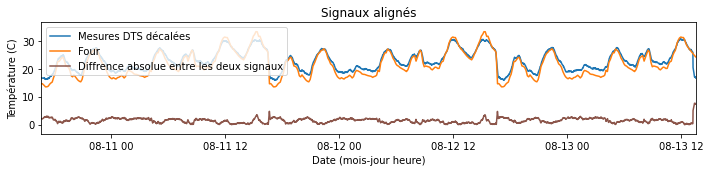

La différence absolue moyenne entre les deux signaux alignés est de 1.42 +/- 0.85 °C


In [20]:
fig, ax_dts = plt.subplots( figsize=(10, 2.5))
ax_dts.plot(date, np.roll(signal_dts, m),label='Mesures DTS décalées')
ax_dts.plot(date,signal_upsample,label='Four')
ax_dts.set_title('Signaux alignés')
ax_dts.set_xlabel('Date (mois-jour heure)')
ax_dts.set_ylabel('Température (C)')
ax_dts.plot(date, np.absolute(signal_upsample - np.roll(signal_dts, m)), linewidth=1.5, color='tab:brown', label='Diffrence absolue entre les deux signaux')
ax_dts.legend(loc='upper left')
ax_dts.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

diff = np.mean(np.absolute(signal_upsample - np.roll(signal_dts, m)))
et = np.std(np.absolute(signal_upsample - np.roll(signal_dts, m)))
print('La différence absolue moyenne entre les deux signaux alignés est de {:.2f} +/- {:.2f} °C'.format(diff, et))

## 3. De 517 m à la fin (555 m)

D'abord, on voit qu'il y a une anomalie qui cause une baisse de température à partie du 11 aout autour de 15h (c'est la même anomalie qui vient du mètre 490 dans le four). 

Sinon, on voit les sections suivantes:

##### Chaudière 2 @ [520, 547]

- Normalement les données sont supposées être les même que la chaudière 1

##### Raccord 2 @ [547, 555]

- Normalement les données sont supposées être très similaire au raccord 1


<AxesSubplot:title={'center':'517 mètres à la fin du circuit'}>

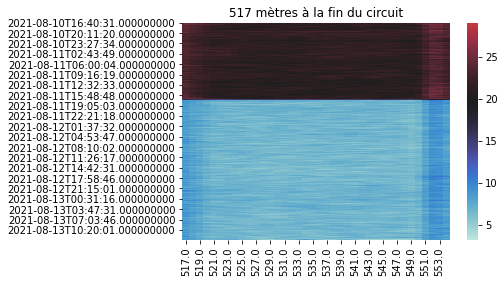

In [21]:
N1=517
N2=-1
df = pd.DataFrame(data=dts[:,N1:N2], columns=pos[N1:N2], index=date)
plt.title('517 mètres à la fin du circuit')
sns.heatmap(df,center=20, cbar=True)

### Correction du offset

Pour corriger le offset qui est appararu le 11 aout @ 15h, on trouve la coupure (spatiale et temporelle) et on applique le offset pour corriger les données

La coupure a commencé le 2021-08-11T17:19:51
La coupure commence au mètre 491.0
Le offset est de : -14.632181078246262 °C


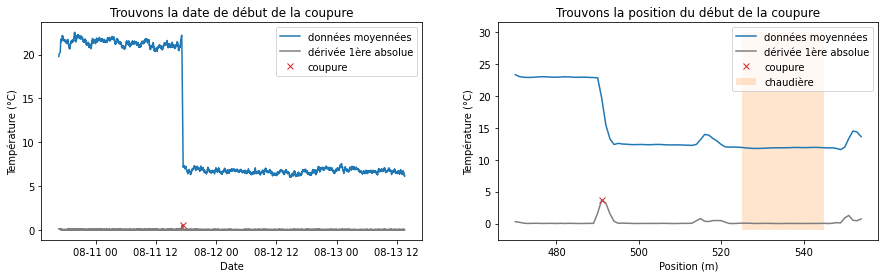

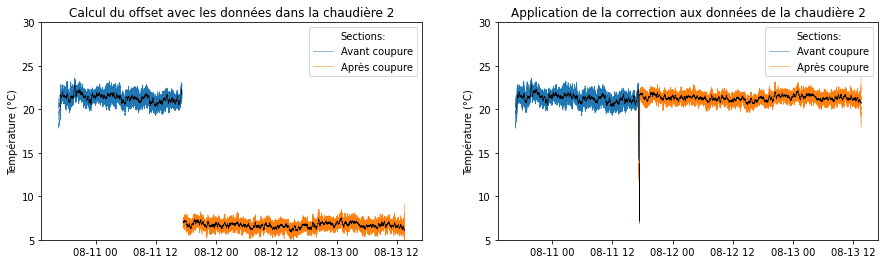

In [22]:

c2 = np.nanmean(dts[:,520:547], axis=1)
g = np.gradient(c2)
d_date = np.argmax(np.absolute(g))

fig,ax = plt.subplots(ncols=2, figsize=(15,4))
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Température (°C)')
ax[0].set_title('Trouvons la date de début de la coupure')
ax[0].plot(date, c2, label='données moyennées')
# ax2 = ax.twinx()
ax[0].plot(date, np.absolute(g), label='dérivée 1ère absolue', color='tab:grey')
ax[0].plot(date[d_date], np.absolute(g)[d_date], 'x', label='coupure', color='tab:red')
_ = ax[0].legend()

print('La coupure a commencé le {}'.format(date[d_date]))

N = 470 # la coupure commence un peu après ça
N2 = 555
c2 = np.nanmean(dts[:,N:N2], axis=0)
g = np.gradient(c2)
d_pos = np.argmax(np.absolute(g))

lim1=525
lim2=545
ax[1].set_xlabel('Position (m)')
ax[1].set_ylabel('Température (°C)')
ax[1].set_title('Trouvons la position du début de la coupure')
ax[1].plot(pos[N:N2], c2, label='données moyennées')
ax[1].fill_between([lim1,lim2], -1, 30, label='chaudière',facecolor='tab:orange', alpha=0.2)
# ax2 = ax.twinx()
ax[1].plot(pos[N:N2], np.absolute(g), label='dérivée 1ère absolue', color='tab:grey')
ax[1].plot(N + pos[d_pos], np.absolute(g)[d_pos], 'x', label='coupure', color='tab:red')
_ = ax[1].legend()

print('La coupure commence au mètre {}'.format(N + pos[d_pos]))
d_pos_ok = N + d_pos


colors = ['tab:blue', 'tab:orange']
fig, ax = plt.subplots(ncols=2,figsize=(15,4))
ax[0].set_title('Calcul du offset avec les données dans la chaudière 2')
ax[0].set_ylabel('Température (°C)')
ax[0].set_ylim(5,30)
a = np.arange(lim1,lim2, step=1)
n = len(a)
cut=15
for i in range(n):
    j = a[i]
    line1, = ax[0].plot(date[:d_date-cut],dts[:d_date-cut,j], linewidth=0.5, color=colors[0])
ax[0].plot(date[:d_date-cut],np.mean(dts[:d_date-cut,lim1:lim2], axis=1), linewidth=0.5, color='k')
a = np.arange(lim1,lim2, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line2, = ax[0].plot(date[d_date+cut:],dts[d_date+cut:,j], linewidth=0.5, color=colors[1])
ax[0].plot(date[d_date+cut:],np.mean(dts[d_date+cut:,lim1:lim2], axis=1), linewidth=0.5, color='k')
_=ax[0].legend([line1,line2], ['Avant coupure','Après coupure'], title='Sections:')

offset = np.mean( dts[d_date+cut:,lim1:lim2]  )  -  np.mean( dts[:d_date-cut,lim1:lim2]  )
print('Le offset est de : {} °C'.format(offset))

dts_corr = dts.copy()
dts_corr[d_date+cut:,d_pos_ok:] += np.absolute(offset)
# arr_cut = np.arange(-cut,cut)
# range_cut = range(len(arr_cut))
# offset_lin = offset/len(arr_cut)
# for i in range_cut:
#     dts_corr[d_date+arr_cut[i]:d_pos_ok:] += offset_lin*i

ax[1].set_title('Application de la correction aux données de la chaudière 2')
ax[1].set_ylabel('Température (°C)')
ax[1].set_ylim(5,30)
a = np.arange(lim1,lim2, step=1)
n = len(a)
cut=15
for i in range(n):
    j = a[i]
    line1, = ax[1].plot(date[:d_date],dts_corr[:d_date,j], linewidth=0.5, color=colors[0])
ax[1].plot(date[:d_date],np.mean(dts_corr[:d_date,lim1:lim2], axis=1), linewidth=0.5, color='k')
a = np.arange(lim1,lim2, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line2, = ax[1].plot(date[d_date:],dts_corr[d_date:,j], linewidth=0.5, color=colors[1])
ax[1].plot(date[d_date:],np.mean(dts_corr[d_date:,lim1:lim2], axis=1), linewidth=0.5, color='k')
_=ax[1].legend([line1,line2], ['Avant coupure','Après coupure'], title='Sections:')



### Résultats de la correction:
**Comparaison de la section autour de la coupure avant et après la correction**

Il y a encore un artéfact, mais c'est déjà mieux

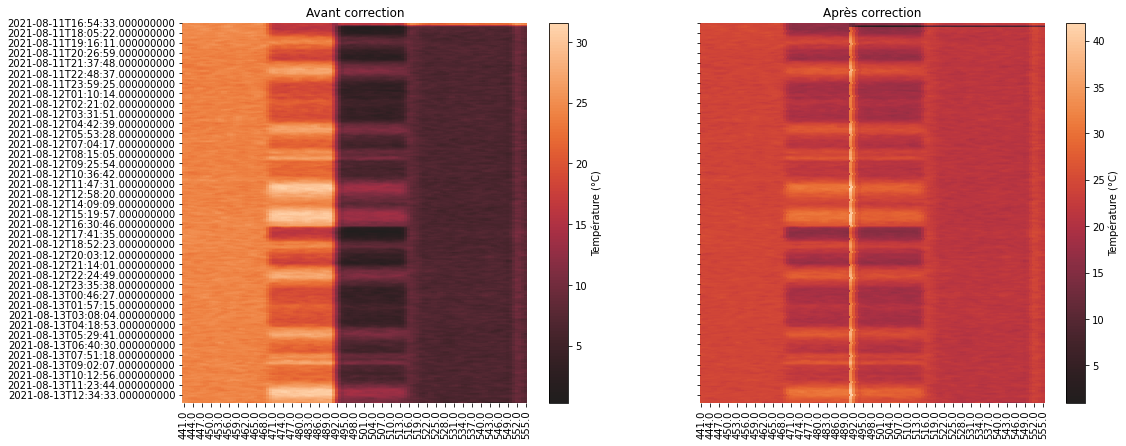

In [23]:
df1 = pd.DataFrame(data=dts[d_date-50:, d_pos_ok-50:], columns=pos[d_pos_ok-50:], index=date[d_date-50:])
df2 = pd.DataFrame(data=dts_corr[d_date-50:, d_pos_ok-50:], columns=pos[d_pos_ok-50:], index=date[d_date-50:])

fig,axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(17,7))
axs[0].set_title('Avant correction')
axs[0].set_ylabel('Date')
axs[0].set_xlabel('Position')
im=sns.heatmap(df1, ax=axs[0],center=0, cbar=False)
mappable = im.get_children()[0]
cbar = plt.colorbar(mappable, ax = axs[0])
cbar.set_label('Température (°C)')
axs[1].set_title('Après correction')
axs[1].set_xlabel('Position')
im=sns.heatmap(df2, ax=axs[1],center=0, cbar=False)
mappable = im.get_children()[0]
cbar = plt.colorbar(mappable, ax = axs[1])
cbar.set_label('Température (°C)')

#### Comparaison des chaudières avant et après correction

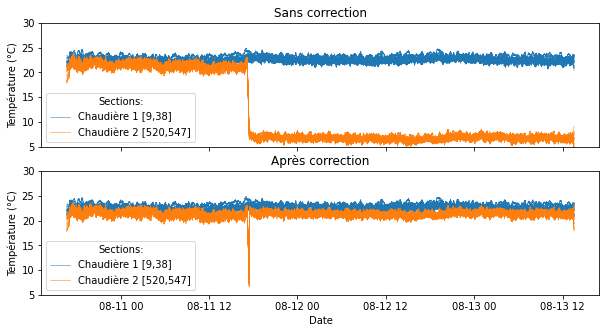

In [24]:
colors = ['tab:blue', 'tab:orange', 'tab:pink', 'tab:grey']
fig, ax = plt.subplots(nrows = 2, sharex=True, figsize=(10,5))
ax[0].set_title('Sans correction')
ax[0].set_ylabel('Température (°C)')
ax[0].set_ylim(5,30)
a = np.arange(9,38, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line1, = ax[0].plot(date,dts[:,j], linewidth=0.5, color=colors[0])
a = np.arange(520,547, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line2, = ax[0].plot(date,dts[:,j], linewidth=0.5, color=colors[1])
_=ax[0].legend([line1,line2], ['Chaudière 1 [9,38]','Chaudière 2 [520,547]'], title='Sections:')

ax[1].set_title('Après correction')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Température (°C)')
ax[1].set_ylim(5,30)
a = np.arange(9,38, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line1, = ax[1].plot(date,dts[:,j], linewidth=0.5, color=colors[0])
a = np.arange(520,547, step=1)
n = len(a)
for i in range(n):
    j = a[i]
    line2, = ax[1].plot(date,dts_corr[:,j], linewidth=0.5, color=colors[1])
_=ax[1].legend([line1,line2], ['Chaudière 1 [9,38]','Chaudière 2 [520,547]'], title='Sections:')

In [25]:
pd.DataFrame(data=dts_corr).to_csv("{}/temp_correction.csv".format(folder), header=False, index=False)

# Données finales après corrections

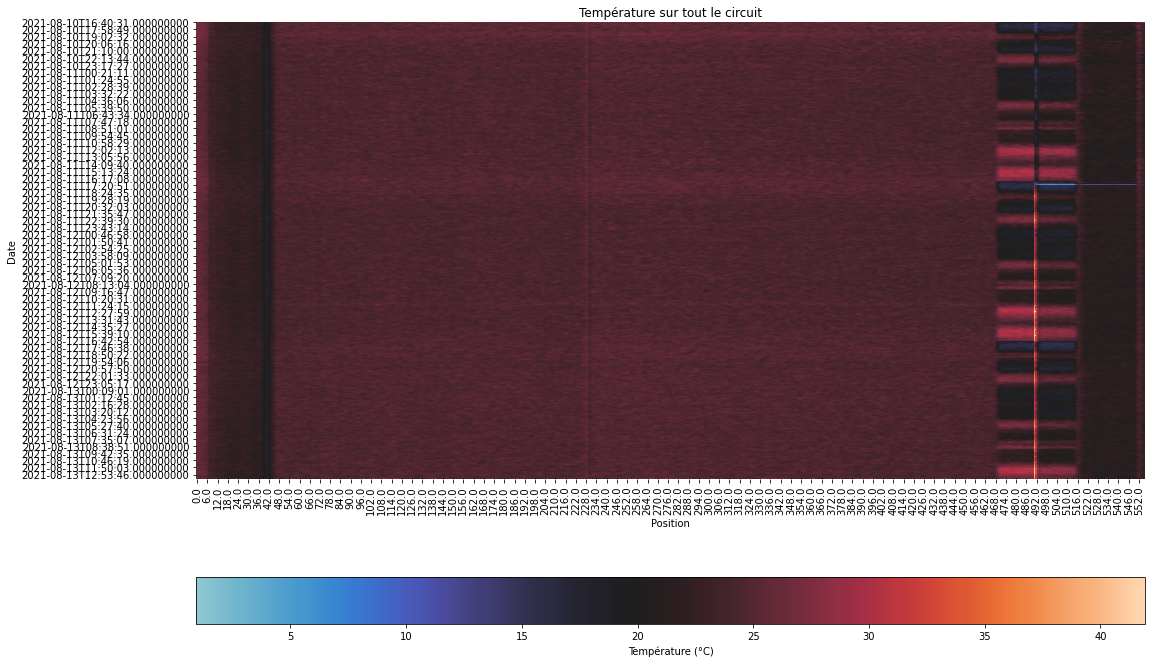

In [26]:
df = pd.DataFrame(data=dts_corr, columns=pos, index=date)

fig,axs = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(17,12))
axs.set_title('Circuit complet (données corrigées)')
im=sns.heatmap(df, ax=axs,center=20, cbar=False)
axs.set_ylabel('Date')
axs.set_xlabel('Position')
axs.set_title('Température sur tout le circuit')
mappable = im.get_children()[0]
cbar = plt.colorbar(mappable, ax = axs, orientation = 'horizontal')
cbar.set_label('Température (°C)')
# plt.savefig('figures/filtre.png')